In [27]:
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# load `.mat` file
data = scipy.io.loadmat('face.mat')

# Images
# N: number of images
# D: number of pixels
X = data['X']  # shape: [D x N]
y = data['l']  # shape: [1 x N]

assert(X.shape[1] == y.shape[1])
# Number of images
D, N = X.shape

# Fix the random seed
np.random.seed(13)

# Cardinality of labels
_card = len(set(y.ravel()))

# Step splitting of dataset
_step = int(N / _card)

# Shape boundaries
_bounds = np.arange(0, N, _step)

# Shapes
shapes = list(zip(_bounds[:-1], _bounds[1:]))

# Training Mask
_mask = []

for _shape in shapes:
    _idx = np.random.choice(
        np.arange(*_shape), int(0.8 * _step), replace=False)
    _mask.append(_idx)

mask_train = np.array(_mask).ravel()

mask_test = np.array(list(set(np.arange(0, N)) - set(mask_train)))

# Partition dataset to train and test sets
X_train, X_test = X[:, mask_train], X[:, mask_test]
y_train, y_test = y[:, mask_train], y[:, mask_test]

In [28]:
class PCA(object):
    """Principle Component Analysis."""

    def __init__(self, n_comps=5, standard=True):
        """Contructor.
        Parameters
        ----------
        n_comps: int
            Number of principle components
        """
        self._fitted = False
        self.n_comps = n_comps
        self.standard = standard
        self.mean = None
        self.U = None

    def fit(self, X):
        """Fit PCA according to `X.cov()`.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.D, N = X.shape
        self.mean = X.mean(axis=1).reshape(-1, 1)
        # center data
        A = X - self.mean
        # covariance matrix
        S = (1 / N) * np.dot(A.T, A)
        
        _l, _v = np.linalg.eig(S)

        _indexes = np.argsort(_l)[::-1]

        # Sorted eigenvalues and eigenvectors
        l, v = _l[_indexes], _v[:, _indexes]

        V = v[:, :self.n_comps]

        _U = np.dot(A, V)

        self.U = _U / np.apply_along_axis(np.linalg.norm, 0, _U)

        W = np.dot(self.U.T, A)

        if self.standard:
            self.W_mean = np.mean(W, axis=1)
            self.W_std = np.std(W, axis=1)

        self._fitted = True

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def transform(self, X):
        """Transform `X` by projecting it to PCA feature space.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """

        Phi = X - self.mean

        W = np.dot(self.U.T, Phi)

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def reconstruct(self, W):
        """Recontruct compressed data.
        Parameters
        ----------
        W: numpy.ndarray
            Projection coefficients matrix
        Returns
        -------
        X_hat: numpy.ndarray
            Reconstructed features matrix
        """
        A_hat = np.dot(self.U, W).reshape(-1, 1)
        return A_hat

In [39]:
# KNN Classifer
from sklearn.neighbors import KNeighborsClassifier

M = 1
standard = False
M_train = []
acc_train = []

while M < 408:

    D, N = X_train.shape

    pca = PCA(n_comps=M, standard=standard)

    W_train = pca.fit(X_train)

    I, K = X_test.shape

    W_test = pca.transform(X_test)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(W_train.T, y_train.T.ravel())
    acc = nn.score(W_test.T, y_test.T.ravel())
    print('Accuracy = %.2f%%' % (acc * 100))
    acc_train.append(acc*100)
    M_train.append(M)
    M = M + 1

Accuracy = 7.14%
Accuracy = 7.14%
Accuracy = 17.86%
Accuracy = 24.11%
Accuracy = 36.61%
Accuracy = 33.93%
Accuracy = 32.14%
Accuracy = 33.93%
Accuracy = 35.71%
Accuracy = 38.39%
Accuracy = 41.96%
Accuracy = 41.96%
Accuracy = 42.86%
Accuracy = 43.75%
Accuracy = 44.64%
Accuracy = 46.43%
Accuracy = 47.32%
Accuracy = 47.32%
Accuracy = 48.21%
Accuracy = 48.21%
Accuracy = 49.11%
Accuracy = 50.00%
Accuracy = 50.00%
Accuracy = 51.79%
Accuracy = 51.79%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 54.46%
Accuracy = 55.36%
Accuracy = 54.46%
Accuracy = 53.57%
Accuracy = 52.68%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 52.68%
Accuracy = 53.57%
Accuracy = 53.57%
Accuracy = 54.46%
Accuracy = 57.14%
Accuracy = 57.14%
Accuracy = 56.25%
Accuracy = 56.25%
Accuracy = 56.25%
Accuracy = 57.14%
Accuracy = 57.14%
Accuracy = 56.25%
Accuracy = 56.25%
Accuracy = 57.14%
Accuracy = 56.25%
Accuracy = 56.25%
Accuracy = 57.14%
Accuracy = 57.14%
Accuracy = 5

Text(0,0.5,'Recogniton Accuracy / %')

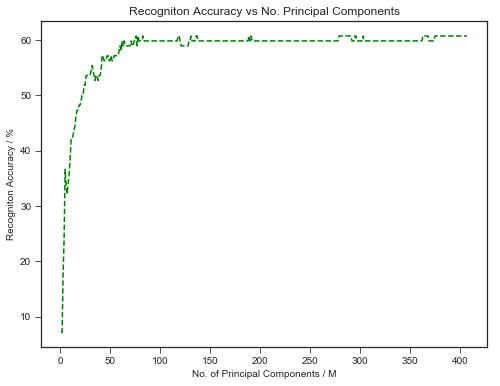

In [42]:
plt.figure(figsize=(8.0, 6.0))
plt.plot(M_train, acc_train, color='green', linestyle='dashed')
plt.title('Recogniton Accuracy vs No. Principal Components')
plt.xlabel('No. of Principal Components / M')
plt.ylabel('Recogniton Accuracy / %')

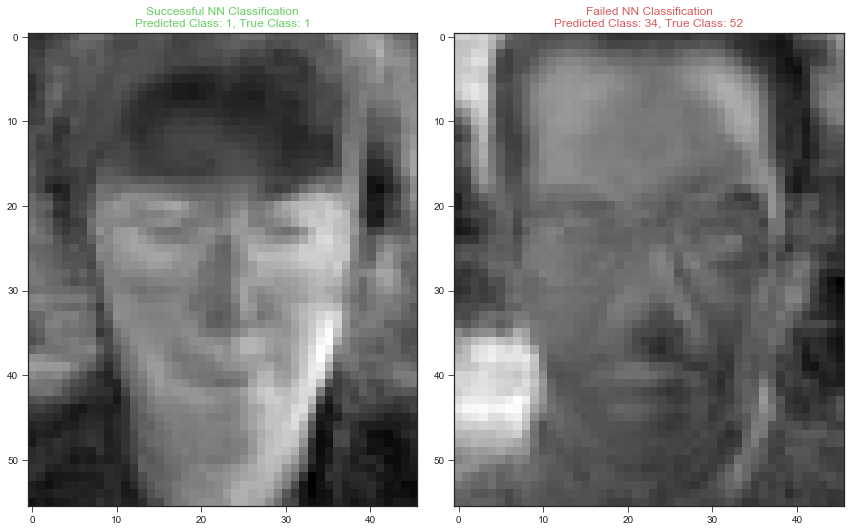

In [23]:
# prettify plots
plt.rcParams['figure.figsize'] = [12.0, 9.0]
sns.set_palette(sns.color_palette("muted"))
_palette = sns.color_palette("muted")
sns.set_style("ticks")

y_hat = nn.predict(W_test.T)

done = {'success': False, 'failure': False}

fig, axes = plt.subplots(ncols=2)

for y, t, w in zip(y_hat, y_test.T.ravel(), W_test.T):
    if y == t and done['success'] is False:
        x_hat = pca.reconstruct(w)
        axes[0].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[0].set_title(
            'Successful NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[1])
        done['success'] = True
    elif y != t and done['failure'] is False:
        x_hat = pca.reconstruct(w)
        axes[1].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[1].set_title(
            'Failed NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[2])
        done['failure'] = True
    #elif done['failure'] is True and done['success'] is True:
     #break

fig.tight_layout()